In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic.ipynb")

# Final Project: Traffic
## Due Date: Monday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own groups**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [3]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
path_traffic_speeds = 'data/movement-speeds-daily-san-francisco-2020-3.csv'
speeds_to_nodes = pd.read_csv(path_traffic_speeds)

speeds_to_nodes

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean
0,281266,702258940,1,59.674042
1,281266,702274215,1,68.444042
2,302876,240259516,1,66.446500
3,302878,437325360,1,65.516850
4,302883,65381191,1,61.880556
...,...,...,...,...
1586647,6569140748,1350115374,31,68.484833
1586648,6570476556,4551993266,31,36.837000
1586649,6573249373,4911384010,31,39.021000
1586650,6573553681,256888796,31,68.728333


In [4]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

_Google Plus codes do not account for population densities, while census tracts do._

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [5]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [6]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [7]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN = r"<node id=\"(\d*)\" lat=\"(.*)\" lon=\"(-\d*.\d*)\""

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130
2,29892598,37.716892,-122.398893
3,30033679,37.599877,-122.376497
4,30033686,37.642167,-122.405946
...,...,...,...
19139,6522255428,37.760543,-122.443563
19140,6522255492,37.759317,-122.444996
19141,6522764204,37.762163,-122.436143
19142,6522764212,37.756061,-122.436761


In [8]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [9]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = speeds_to_nodes.merge(node_to_gps, left_on='osm_start_node_id', right_on='osm_node_id')
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194
...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206


In [10]:
grader.check("q1bii")

q1bii results: All test cases passed!

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [11]:
speeds_to_gps['plus_latitude_idx'] = (speeds_to_gps['Latitude'] / 0.012).astype('int')
speeds_to_gps['plus_longitude_idx'] = (speeds_to_gps['Longitude'] / 0.012).astype('int')


speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194,3139,-10199
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194,3139,-10199
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194,3139,-10199
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194,3139,-10199
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194,3139,-10199
...,...,...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126,3144,-10208
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763,3135,-10201
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206,3144,-10208
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206,3144,-10208


In [12]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [13]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
num_pluscode_regions = speeds_to_gps.groupby(['plus_latitude_idx', 'plus_longitude_idx']).size().shape[0]
num_pluscode_regions

276

In [14]:
grader.check("q1biv")

q1biv results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



_Being that plus codes are strictly geographically determined and do not take population into account, they may not as effectively capture meaningful subpopulations. Still, variance in speeds between subpopulations outweigh variance within a population (10.135 to 8.684)._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

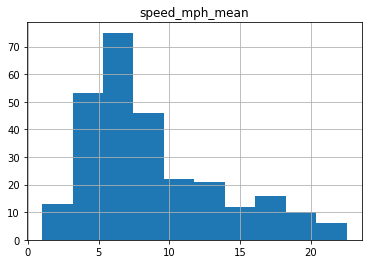

In [15]:
speed_variance_by_pluscode = speeds_to_gps.groupby(['plus_latitude_idx', 'plus_longitude_idx']).agg(np.std) # compute traffic speed variance in each plus code region
# plot a histogram
speed_variance_by_pluscode.hist(column='speed_mph_mean')
average_variance_by_pluscode = speed_variance_by_pluscode['speed_mph_mean'].mean()
variance_average_by_pluscode = speeds_to_gps.groupby(['plus_latitude_idx', 'plus_longitude_idx']).agg(np.mean)['speed_mph_mean'].std()

In [16]:
print(average_variance_by_pluscode, variance_average_by_pluscode)

8.684748294968637 10.13573858675904


<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [17]:
speed_variance_by_pluscode

osm_start_node_id  osm_end_node_id  \
plus_latitude_idx plus_longitude_idx                                       
3128              -10209                   2.585668e+09     2.580747e+09   
                  -10197                   9.349597e+08     1.464673e+09   
                  -10193                   1.744691e+09     1.716313e+09   
3129              -10209                   0.000000e+00     1.225580e+08   
                  -10198                   3.860295e+08     2.574988e+08   
...                                                 ...              ...   
3160              -10197                   2.150245e+09     2.162032e+09   
                  -10196                   2.090294e+09     2.102317e+09   
                  -10195                   2.092095e+09     2.171028e+09   
                  -10194                   2.060321e+09     1.966909e+09   
                  -10193                   1.834000e+09     1.749191e+09   

                                           day  speed_mph_mean   osm_node_id  \
plus_latitude_idx plus_longitude_idx                                           
3128              -10209              2.846747        3.650232  2.585668e+09   
                  -10197              8.106979       20.704487  9.349597e+08   
                  -10193              4.487313       12.342234  1.744691e+09   
3129              -10209              4.209477        4.083821  0.000000e+00   
                  -10198              8.433481       21.390912  3.860295e+08   
...                                        ...             ...           ...   
3160              -10197              6.820154       15.293632  2.150245e+09   
                  -10196              6.100627       17.915911  2.090294e+09   
                  -10195              6.457647       14.243592  2.092095e+09   
                  -10194              6.719457       12.237229  2.060321e+09   
                  -10193              8.066560       17.590817  1.834000e+09   

                                      Latitude  Longitude  
plus_latitude_idx plus_longitude_idx                       
3128              -10209              0.001958   0.001147  
                  -10197              0.001866   0.001978  
                  -10193              0.000719   0.001426  
3129              -10209              0.000000   0.000000  
                  -10198              0.001853   0.000826  
...                                        ...        ...  
3160              -10197              0.000896   0.003053  
                  -10196              0.002427   0.002744  
                  -10195              0.002449   0.002548  
                  -10194              0.001620   0.002865  
                  -10193              0.001567   0.001888  

[276 rows x 7 columns]

In [18]:
grader.check("q1bv3")

q1bv3 results: All test cases passed!

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [19]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."
2,3,"18300 Sutter Boulevard, Morgan Hill","MULTIPOLYGON (((-121.67978 37.15859, -121.6719..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","MULTIPOLYGON (((-121.35921 38.57175, -121.3462..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","MULTIPOLYGON (((-121.37512 38.55309, -121.3715..."
...,...,...,...
2705,2706,"10000 Bobbell Drive, Elk Grove","MULTIPOLYGON (((-121.48392 38.40874, -121.4787..."
2706,2707,"400 Ericwood Court, Manteca","MULTIPOLYGON (((-121.22695 37.82647, -121.2185..."
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506..."
2708,2709,"1200 Halyard Drive, West Sacramento","MULTIPOLYGON (((-121.58346 38.57860, -121.5827..."


In [20]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [21]:
speeds_to_points = gpd.GeoDataFrame(speeds_to_gps, geometry=gpd.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude), crs=4326)
speeds_to_tract = tract_to_gps.sjoin(speeds_to_points)

speeds_to_tract

,MOVEMENT_ID,DISPLAY_NAME,geometry,index_right,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",346374,5429620647,65333834,16,4.390000,5429620647,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",346370,5429620647,65333834,12,8.373600,5429620647,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",346366,5429620647,65333831,10,10.491000,5429620647,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",346360,5429620647,65333834,5,11.634500,5429620647,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",346361,5429620647,65333831,6,5.826500,5429620647,37.784356,-122.416866,3148,-10201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",393115,65436480,4550820797,6,23.799333,65436480,37.661119,-122.438615,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",393127,65436480,4552055202,13,23.748000,65436480,37.661119,-122.438615,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",395725,267053289,5435703115,9,21.266000,267053289,37.663610,-122.441970,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",412803,2278938365,267053289,9,10.968000,2278938365,37.664004,-122.442453,3138,-10203


In [22]:
grader.check("q1cii")

q1cii results: All test cases passed!

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [23]:
speeds_by_tract = speeds_to_tract.groupby('MOVEMENT_ID').mean()
num_census_tracts = speeds_by_tract.shape[0]

num_census_tracts

295

In [24]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



_Census tracts capture meaningful subpopulations primarily because it is both determined geographically and by population according to the census. As a result, the variance within a subpopulation is lower than that using plus codes (8.300 to 8.684). Additionally, differences between subpopulations outweigh differences within a subpopulation (8.346 to 8.300), indicating individual clusters more accurately represent regions with different traffic speeds._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

In [25]:
speed_variance_by_tract = speeds_to_tract.groupby('MOVEMENT_ID').agg(np.std)
average_variance_by_tract = speed_variance_by_tract['speed_mph_mean'].mean()
variance_average_by_tract = speeds_to_tract.groupby('MOVEMENT_ID').agg(np.mean)['speed_mph_mean'].std()

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [26]:
speed_variance_by_tract

,index_right,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
MOVEMENT_ID,,,,,,,,,,
9,86182.932337,1.699601e+09,1.661318e+09,8.561287,3.821144,1.699601e+09,0.000804,0.000967,0.000000,0.000000
20,57182.959585,6.941097e+08,9.991617e+08,8.636868,5.522853,6.941097e+08,0.000472,0.002250,0.468397,0.000000
21,81071.144418,1.549197e+09,1.408258e+09,4.317201,3.640453,1.549197e+09,0.001168,0.001172,0.000000,0.000000
44,144311.162081,2.164862e+09,2.172881e+09,7.579068,6.634154,2.164862e+09,0.002510,0.002326,0.310918,0.393078
78,171356.415485,1.767481e+09,2.019760e+09,5.177747,3.838873,1.767481e+09,0.002945,0.002992,0.449092,0.498637
...,...,...,...,...,...,...,...,...,...,...
2691,577.490383,2.190798e+04,1.736377e+04,3.309438,3.379664,2.190798e+04,0.000505,0.003673,0.000000,0.487950
2694,102197.444956,1.760004e+09,1.743062e+09,8.184973,5.787065,1.760004e+09,0.000756,0.003028,0.473769,0.000000
2695,143462.137296,2.221266e+09,2.301651e+09,5.799584,4.617596,2.221266e+09,0.001892,0.003580,0.000000,0.000000


In [27]:
print(average_variance_by_tract, variance_average_by_tract)

8.300873802949297 8.346122597861662


In [28]:
grader.check("q1civ3")

q1civ3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

_A "good" metric for a spacial structure entails accurately dividing a region into parts that effectively captures its differences, in this case areas of different traffic speeds. This means that the variance within a cluster is relatively low while the variance between clusters is relatively high. Between plus codes and census tracts, the latter clearly seems to capture different traffic regions more effectively, as it takes population from the census into account. However, using a different metric, it may be helpful to explore dividing regions differently, such as the hexagonal structure in Uber's H3. According to their website, this would help "minimize quantization error introduced when users move through a city" and allow us to "approximate radiuses easily"._

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

_The long tail distribution of high speed traffic likely corresponds to the bridges and highways in San Francisco. Because commute to work was significantly cut down due to the the shelter in place, long distance commute through these areas probably saw a significant hit._

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [29]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
averages_pre = speeds_to_tract[speeds_to_tract['day'] < 14].groupby('MOVEMENT_ID').mean()['speed_mph_mean'] 
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_pre_named = speeds_to_tract[speeds_to_tract['day'] < 14].groupby('MOVEMENT_ID').mean() 
averages_pre_named

,index_right,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
MOVEMENT_ID,,,,,,,,,,
9,135288.841699,8.877688e+08,8.809746e+08,6.949807,14.585102,8.877688e+08,37.785402,-122.415596,3148.000000,-10201.000000
20,81590.278302,2.032479e+08,3.415383e+08,7.051887,15.679922,2.032479e+08,37.787680,-122.418813,3148.323113,-10201.000000
21,192207.083333,1.163141e+09,9.031954e+08,6.696429,14.292445,1.163141e+09,37.801973,-122.437902,3150.000000,-10203.000000
44,195230.729070,1.591199e+09,1.646409e+09,6.895349,23.353083,1.591199e+09,37.723772,-122.397314,3143.143023,-10199.187209
78,193347.731760,8.058923e+08,9.684868e+08,6.502146,16.213552,8.058923e+08,37.729894,-122.388840,3143.721030,-10198.545064
...,...,...,...,...,...,...,...,...,...,...
2691,416219.166667,6.543152e+07,6.542733e+07,7.666667,20.746333,6.543152e+07,37.600554,-122.413699,3133.000000,-10200.666667
2694,133778.435789,8.938543e+08,9.736892e+08,6.936842,17.042386,8.938543e+08,37.787452,-122.429678,3148.271579,-10202.000000
2695,270056.705298,1.119980e+09,1.247396e+09,6.605960,20.029011,1.119980e+09,37.744170,-122.490533,3145.000000,-10207.000000


In [30]:
grader.check("q2ai2")

q2ai2 results: All test cases passed!

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [31]:
bottom10_averages_pre = averages_pre_named.sort_values(by='speed_mph_mean').head(10)
bottom10_averages_pre

,index_right,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
MOVEMENT_ID,,,,,,,,,,
1691,157033.605590,1.291981e+09,1.438929e+09,6.776398,12.417079,1.291981e+09,37.785619,-122.410310,3148.000000,-10200.211180
2340,216683.805556,2.472741e+09,1.615193e+09,6.866667,12.595120,2.472741e+09,37.782842,-122.410860,3148.000000,-10200.361111
1688,132237.887955,1.089534e+09,1.240683e+09,6.738095,12.945291,1.089534e+09,37.792758,-122.411655,3149.000000,-10200.418768
651,157814.252822,4.211215e+08,4.202369e+08,6.329571,13.195865,4.211215e+08,37.754983,-122.411794,3146.000000,-10200.582393
643,157567.901235,1.064910e+09,1.181588e+09,7.016461,13.490311,1.064910e+09,37.785075,-122.419476,3148.000000,-10201.000000
1689,161141.481941,1.367523e+09,1.244759e+09,6.854987,13.502505,1.367523e+09,37.790417,-122.403537,3148.863073,-10199.834501
1244,179264.310518,1.708220e+09,1.665047e+09,6.707846,13.549474,1.708220e+09,37.793884,-122.408738,3149.000000,-10200.000000
1245,149514.953390,6.548649e+08,5.622516e+08,6.949153,13.570625,6.548649e+08,37.786764,-122.411725,3148.000000,-10200.440678
644,196383.461538,1.715898e+09,2.541167e+09,7.000000,13.626251,1.715898e+09,37.783493,-122.411781,3148.000000,-10200.461538


In [32]:
grader.check("q2ai3")

q2ai3 results: All test cases passed!

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [33]:
top10_averages_pre = averages_pre_named.sort_values(by='speed_mph_mean', ascending=False).head(10)
top10_averages_pre

,index_right,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
MOVEMENT_ID,,,,,,,,,,
285,254396.333333,1.855803e+09,1.391415e+09,7.000000,59.498552,1.855803e+09,37.822223,-122.324571,3151.000000,-10193.000000
495,248758.439252,8.284489e+08,7.887680e+08,6.504673,53.867847,8.284489e+08,37.621593,-122.427426,3134.700935,-10202.000000
1653,213066.326829,1.307517e+09,1.285079e+09,6.458537,47.318340,1.307517e+09,37.927366,-122.378027,3160.000000,-10197.725203
2339,295024.802768,7.627245e+08,8.434683e+08,6.307958,47.225137,7.627245e+08,37.592154,-122.416111,3132.062284,-10200.875433
1744,277152.887500,2.943644e+08,2.896095e+08,6.900000,45.492292,2.943644e+08,37.597626,-122.419969,3132.918750,-10201.037500
2244,273063.206667,3.769073e+08,7.833941e+08,5.433333,44.304919,3.769073e+08,37.551620,-122.358197,3128.606667,-10195.960000
2660,257267.474359,2.002299e+09,1.970638e+09,6.935897,43.848188,2.002299e+09,37.869640,-122.507327,3155.038462,-10208.115385
1955,307455.755435,2.163628e+09,2.208317e+09,5.690217,42.784267,2.163628e+09,37.555989,-122.514691,3129.027174,-10209.000000
1732,239491.691943,7.900908e+08,8.978459e+08,6.800948,40.587037,7.900908e+08,37.675633,-122.488212,3139.037915,-10206.969194


In [34]:
grader.check("q2ai4")

q2ai4 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

<AxesSubplot:>

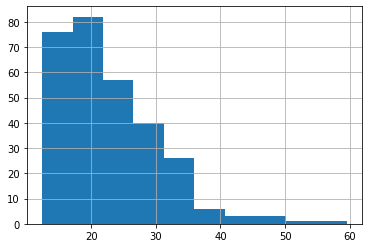

In [35]:
averages_pre_named['speed_mph_mean'].hist()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

_Pre-lockdown speeds peaked at around 20 mph while post-lockdown speeds peaked at around 25 mph. Additionally, the distributition for pre-lockdown speeds saw a smoother decline when looking at higher speeds, whereas the distribution for post lockdown speeds saw a signficantly steeper dropoff at 30 mph._

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [36]:
# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
# Autograder expects this to be a series
averages_post = speeds_to_tract[speeds_to_tract['day'] > 13].groupby('MOVEMENT_ID').mean()['speed_mph_mean'] 
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_post_named = speeds_to_tract[speeds_to_tract['day'] > 13].groupby('MOVEMENT_ID').mean()
averages_post_named

,index_right,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
MOVEMENT_ID,,,,,,,,,,
9,128236.288210,7.432695e+08,8.449498e+08,21.510917,16.143154,7.432695e+08,37.785629,-122.415726,3148.000000,-10201.000000
20,80280.875878,1.971781e+08,3.367894e+08,21.749415,16.871488,1.971781e+08,37.787688,-122.418681,3148.325527,-10201.000000
21,201553.500000,1.325235e+09,9.412764e+08,14.978261,15.754795,1.325235e+09,37.802303,-122.437594,3150.000000,-10203.000000
44,176083.811671,1.704050e+09,1.710056e+09,20.419098,25.956602,1.704050e+09,37.722638,-122.397473,3143.029178,-10199.198939
78,163606.782609,5.618840e+08,1.077411e+09,18.869565,16.476000,5.618840e+08,37.730542,-122.388594,3143.717391,-10198.521739
...,...,...,...,...,...,...,...,...,...,...
2691,415827.000000,6.541655e+07,6.541655e+07,14.000000,17.917000,6.541655e+07,37.600898,-122.416208,3133.000000,-10201.000000
2694,139708.496124,1.041626e+09,8.655345e+08,21.344961,22.128519,1.041626e+09,37.787857,-122.429254,3148.465116,-10202.000000
2695,239465.957746,1.378815e+09,1.376088e+09,17.915493,23.440404,1.378815e+09,37.744034,-122.492557,3145.000000,-10207.000000


In [37]:
grader.check("q2aii2")

q2aii2 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

<AxesSubplot:>

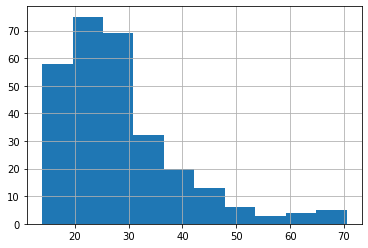

In [38]:
averages_post_named['speed_mph_mean'].hist()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

<AxesSubplot:>

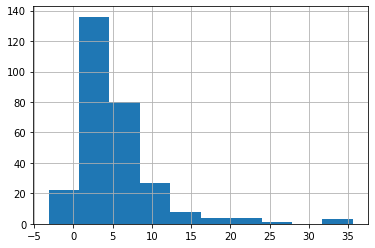

In [39]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
differences = averages_post - averages_pre
# plot the differences
differences.hist()

In [40]:
grader.check("q2aiii")

q2aiii results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

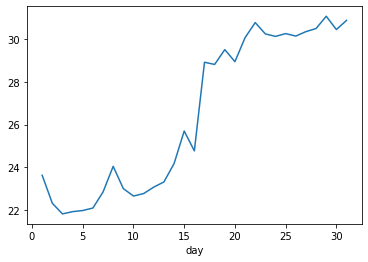

In [41]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby('day').mean()['speed_mph_mean']
speeds_daily.plot();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

_The change in speeds increases sharply around the 15th day, in which the shelter in place and COVID lockdowns were enforced._

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

In [42]:
grader.check("q2aiv3")

q2aiv3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [43]:
corr_pre_diff = differences.corr(averages_pre)
corr_post_diff = differences.corr(averages_post)
corr_pre_diff, corr_post_diff

(0.46330063805801847, 0.7926799984780658)

In [44]:
grader.check("q2av2")

q2av2 results: All test cases passed!

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

_One area of interest is a local extrema at Mill Valley, in which the region contains a lower average speed than its surroundings. Additionally, the northeastern region of San Francisco which contain primarily tourist attractions are relatively slow on average._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

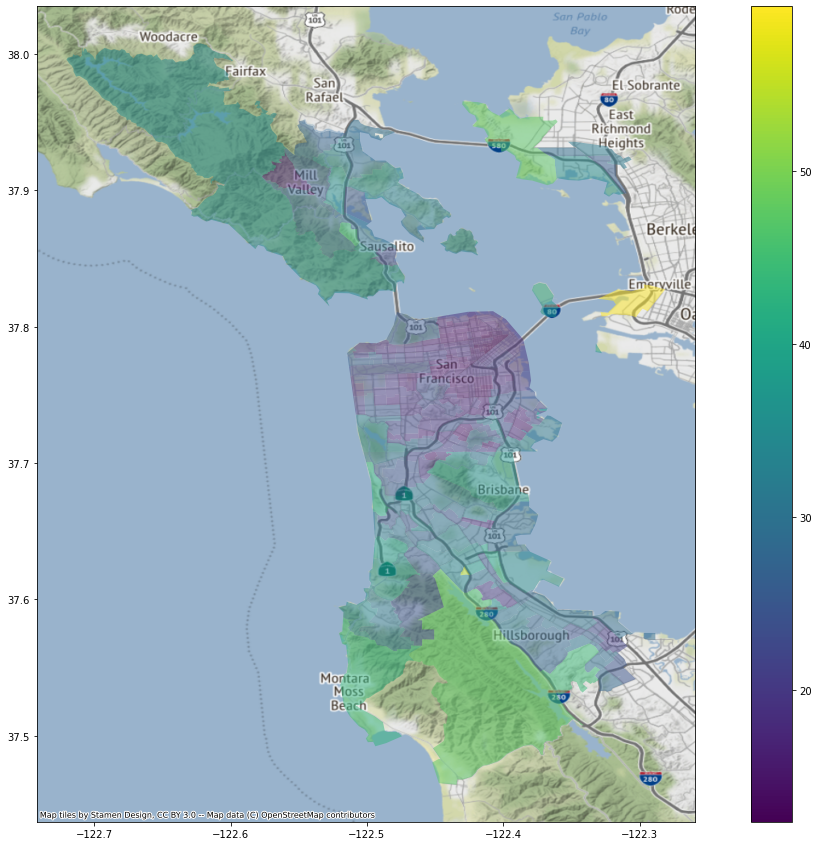

In [45]:
pre_geom = averages_pre_named.merge(speeds_to_tract[['MOVEMENT_ID', 'geometry']], left_on='MOVEMENT_ID', right_on='MOVEMENT_ID').drop_duplicates()
heatmap = pre_geom.plot(column='speed_mph_mean', figsize=(20, 15), legend=True, alpha=0.5)
cx.add_basemap(heatmap, crs=pre_geom.crs)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

_High density regions in San Francisco saw a relatively low change to speeds on average, probably due to the fact that regardless of the shelter in place, people needed to get around for get around for basic services. We also see a local extrema at Hillsborough, which saw a difference of nearly 35 mph._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

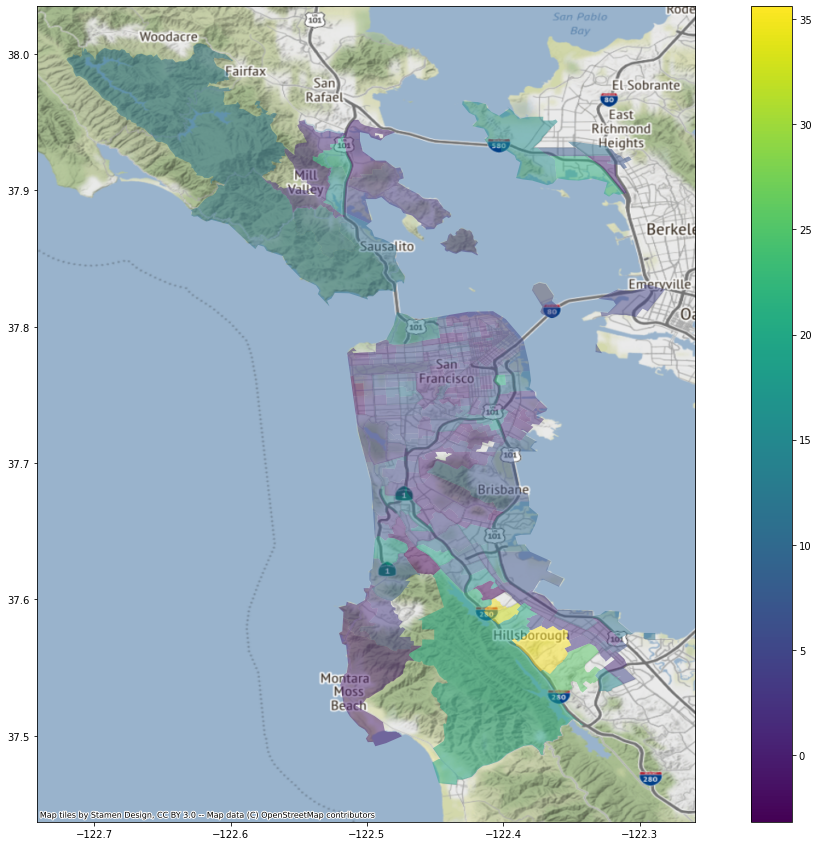

In [46]:
post_geom = speeds_to_tract[['MOVEMENT_ID', 'geometry']].merge(differences.to_frame(), on='MOVEMENT_ID').drop_duplicates()
heatmap_dif = post_geom.plot(column='speed_mph_mean', figsize=(20, 15), legend=True, alpha=0.5)
cx.add_basemap(heatmap_dif, crs=post_geom.crs)

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [47]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1
1,1277,"300 Hayes Street, Civic Center, San Francisco",20,"900 Sutter Street, Lower Nob Hill, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",291,179,470,1
2,1277,"300 Hayes Street, Civic Center, San Francisco",21,"3400 Pierce Street, Marina District, San Franc...","3/1/2020 - 3/1/2020, Every day, Daily Average",635,438,920,1
3,1277,"300 Hayes Street, Civic Center, San Francisco",44,"1700 Egbert Avenue, Bayview, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",786,566,1090,1
4,1277,"300 Hayes Street, Civic Center, San Francisco",46,"500 Chester Street, West Oakland, Oakland","3/1/2020 - 3/1/2020, Every day, Daily Average",891,682,1162,1
...,...,...,...,...,...,...,...,...,...
10333,1277,"300 Hayes Street, Civic Center, San Francisco",2624,"1300 16th Avenue, Inner Sunset, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",502,411,611,31
10334,1277,"300 Hayes Street, Civic Center, San Francisco",2643,"1300 Egbert Avenue, Bayview, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",571,475,685,31
10335,1277,"300 Hayes Street, Civic Center, San Francisco",2673,"100 Rutledge Street, Bernal Heights, San Franc...","3/31/2020 - 3/31/2020, Every day, Daily Average",367,265,507,31
10336,1277,"300 Hayes Street, Civic Center, San Francisco",2694,"1900 Buchanan Street, Western Addition, San Fr...","3/31/2020 - 3/31/2020, Every day, Daily Average",222,167,294,31


In [48]:
hayes_map = times_to_tract.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
hayes_map = gpd.GeoDataFrame(hayes_map)

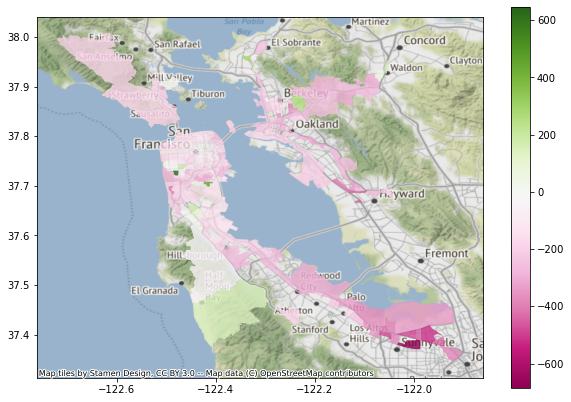

In [49]:
hayes_prelockdown = hayes_map[hayes_map['day'] < 14]
hayes_postlockdown = hayes_map[hayes_map['day'] > 14]
hayes_precovid_means = gpd.GeoDataFrame(hayes_prelockdown.groupby(['Destination Movement ID'])[['Mean Travel Time (Seconds)']].agg(np.mean).merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID'))
hayes_postlockdown_means = gpd.GeoDataFrame(hayes_postlockdown.groupby(['Destination Movement ID'])[['Mean Travel Time (Seconds)']].agg(np.mean).merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID'))
hayes_diff = hayes_precovid_means.merge(hayes_postlockdown_means, on='MOVEMENT_ID')
hayes_diff['Travel Time Difference'] = hayes_diff['Mean Travel Time (Seconds)_y'] - hayes_diff['Mean Travel Time (Seconds)_x']
hayes_diff['geometry'] = hayes_diff['geometry_x']
hayes_diff = gpd.GeoDataFrame(hayes_diff)
hayes_diff
diff_plot = hayes_diff.plot(column='Travel Time Difference', figsize=(10,7), legend=True, alpha=0.8, cmap='PiYG')
cx.add_basemap(diff_plot, crs=hayes_diff.crs)

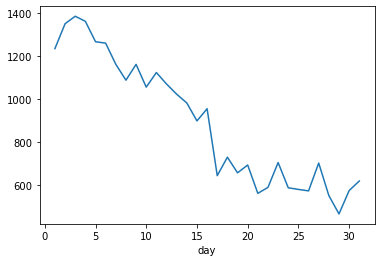

In [50]:
hayes_speeds = times_to_tract.groupby('day').mean()["Mean Travel Time (Seconds)"]
hayes_speeds.plot();

In [51]:
import seaborn as sns
hayes_map = times_to_tract.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
hayes_map = gpd.GeoDataFrame(hayes_map)

def dest_dist(destination_ids, data):
    for destination_id in destination_ids:
        dest_map = data[data['Destination Movement ID']==destination_id]
        sns.lineplot(data=dest_map, x='day', y='Mean Travel Time (Seconds)')

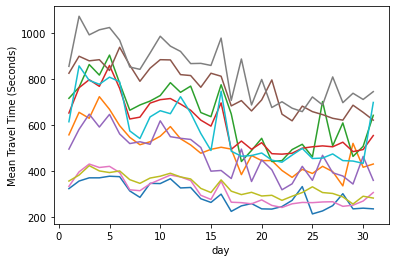

In [52]:
popular_destinations = hayes_map['Destination Movement ID'].value_counts()[:10].index.to_list()
dest_dist(popular_destinations, hayes_map)

# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [53]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    return df[['day', 'speed_mph_mean', 'MOVEMENT_ID']].pivot_table(index='MOVEMENT_ID', columns='day')

time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]

In [54]:
grader.check("q4ai1")

q4ai1 results: All test cases passed!

In [55]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a `day` column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    """
    X_train = []
    for i in np.arange(df.shape[1] - n_val - T):
        for j in np.arange(df.shape[0]):
            X_train.append(df.iloc[j, i:T+i])
            
        
    y_train = []
    for i in np.arange(T, df.shape[1] - n_val):
        for j in np.arange(df.shape[0]):
            y_train.append(df.iloc[j, i])
    
    
    X_val = []
    for i in np.arange(df.shape[1] - n_val - T, df.shape[1] - T):
        for j in np.arange(df.shape[0]):
            X_val.append(df.iloc[j, i:T+i])

    
    y_val = []
    for i in np.arange(df.shape[1] - n_val, df.shape[1]):
        for j in np.arange(df.shape[0]):
            y_val.append(df.iloc[j, i])
    
    
    return np.asarray(X_train, dtype="object"), np.asarray(y_train, dtype="object"), np.asarray(X_val, dtype="object"), np.asarray(y_val, dtype="object")


def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """
    if not len(X):
        return X, y
    
    concat = np.column_stack((X,y)).tolist()
    removed = np.delete(concat, np.argwhere(np.isnan(concat))[:,0], axis=0)
    new_X = removed[:, 0:X.shape[1]]
    new_y = removed[:, X.shape[1]:X.shape[1]+1]
    

    return new_X, new_y.reshape((new_y.shape[0],))
    
    
answer = time_series_to_numpy(time_series, 10, 2)
answer2 = remove_nans(answer[0], answer[1])

In [56]:
grader.check("q4ai2")

q4ai2 results: All test cases passed!

In [57]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above `time_series_to_numpy` and `remove_nans`
    
    For description of arguments, see `time_series_to_numpy` docstring.
    """
    X_train, y_train, X_val, y_val = time_series_to_numpy(time_series, T, n_val)
    X_train, y_train = remove_nans(X_train, y_train)
    X_val, y_val = remove_nans(X_val, y_val)
    return X_train, y_train, X_val, y_val
    
    
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)

In [58]:
grader.check("q4ai3")

q4ai3 results: All test cases passed!

In [59]:
time_series

speed_mph_mean                                              \
day                     1          2          3          4          5    
MOVEMENT_ID                                                              
9                16.196918  14.395121  13.868696  14.225414  14.312199   
20               17.418045  15.460956  15.463297  15.419764  15.291956   
21               15.141171  13.176998  13.781490  14.052113  14.078134   
44               25.079544  23.492586  22.727711  22.274143  21.874703   
78               16.174464  16.755496  16.039120  16.118401  15.665069   
...                    ...        ...        ...        ...        ...   
2691                   NaN        NaN        NaN        NaN  18.600000   
2694             17.809761  16.725889  16.530783  16.446517  16.503053   
2695             20.106061  20.228850  19.849135  20.145877  22.357605   
2700             34.586890  31.372308  30.866382  31.000998  31.636377   
2708             25.176235  24.725863  24.130040  24.287102  24.364056   

                                                                    ...  \
day                 6          7          8          9          10  ...   
MOVEMENT_ID                                                         ...   
9            13.811991  15.508637  16.210738  14.845320  14.711534  ...   
20           15.227310  17.088325  18.088862  16.178105  15.295494  ...   
21           13.636357  13.958269  14.642295  15.616215  14.850471  ...   
44           23.082414  22.875819  25.653848  23.501387  22.739869  ...   
78           15.797723  15.302616  19.284080  16.253357  16.131290  ...   
...                ...        ...        ...        ...        ...  ...   
2691         17.787000  23.473000        NaN  19.038000        NaN  ...   
2694         16.652473  17.427329  18.057287  17.310272  16.998730  ...   
2695         19.250479  19.223717  19.471282  20.497077  20.401085  ...   
2700         30.213992  33.581884  35.443617  32.179867  32.951855  ...   
2708         25.090063  25.552157  26.296112  25.512403  24.886063  ...   

                                                                               \
day                 22         23         24         25         26         27   
MOVEMENT_ID                                                                     
9            15.880078  17.019573  15.527393  15.925605  15.959744  17.317841   
20           18.843376  17.029943  16.286795  17.007889  15.205696  17.461643   
21                 NaN        NaN        NaN        NaN        NaN        NaN   
44           24.381933  25.350188  31.126033        NaN  22.518500  27.697570   
78                 NaN        NaN  15.690000        NaN        NaN  16.849000   
...                ...        ...        ...        ...        ...        ...   
2691               NaN        NaN        NaN        NaN        NaN        NaN   
2694         23.886576  23.410192  23.302396  23.031966  23.107702  23.581885   
2695         29.218800        NaN        NaN        NaN  23.396500        NaN   
2700         47.265544  39.722920  42.812205  39.087122  54.935270  40.893501   
2708               NaN  19.323625  27.792333  25.255979  25.388000  24.786000   

                                                         
day                 28         29         30         31  
MOVEMENT_ID                                              
9            17.845053  17.839214  15.743376  15.797248  
20           16.997424  19.024721  14.134949  17.287814  
21                 NaN        NaN        NaN        NaN  
44           26.899667  19.777429  24.385409  24.683422  
78                 NaN        NaN  16.493000  16.767400  
...                ...        ...        ...        ...  
2691               NaN        NaN        NaN        NaN  
2694         24.382866  23.278001  23.426889  24.056357  
2695         19.708000  26.461900        NaN  19.959500  
2700         45.208787  60.177978  38.714434  48.398038  
2708         27.643333  27.497250  

In [60]:
time_series_pre

speed_mph_mean                                              \
day                     1          2          3          4          5    
MOVEMENT_ID                                                              
9                16.196918  14.395121  13.868696  14.225414  14.312199   
20               17.418045  15.460956  15.463297  15.419764  15.291956   
21               15.141171  13.176998  13.781490  14.052113  14.078134   
44               25.079544  23.492586  22.727711  22.274143  21.874703   
78               16.174464  16.755496  16.039120  16.118401  15.665069   
...                    ...        ...        ...        ...        ...   
2691                   NaN        NaN        NaN        NaN  18.600000   
2694             17.809761  16.725889  16.530783  16.446517  16.503053   
2695             20.106061  20.228850  19.849135  20.145877  22.357605   
2700             34.586890  31.372308  30.866382  31.000998  31.636377   
2708             25.176235  24.725863  24.130040  24.287102  24.364056   

                                                                               \
day                 6          7          8          9          10         11   
MOVEMENT_ID                                                                     
9            13.811991  15.508637  16.210738  14.845320  14.711534  13.739901   
20           15.227310  17.088325  18.088862  16.178105  15.295494  14.637109   
21           13.636357  13.958269  14.642295  15.616215  14.850471  13.790100   
44           23.082414  22.875819  25.653848  23.501387  22.739869  23.756560   
78           15.797723  15.302616  19.284080  16.253357  16.131290  15.773117   
...                ...        ...        ...        ...        ...        ...   
2691         17.787000  23.473000        NaN  19.038000        NaN        NaN   
2694         16.652473  17.427329  18.057287  17.310272  16.998730  16.891788   
2695         19.250479  19.223717  19.471282  20.497077  20.401085  23.870537   
2700         30.213992  33.581884  35.443617  32.179867  32.951855  31.574525   
2708         25.090063  25.552157  26.296112  25.512403  24.886063  23.902599   

                                   
day                 12         13  
MOVEMENT_ID                        
9            14.391436  13.955833  
20           14.282602  14.437358  
21           14.573349  15.177251  
44           24.989269  23.176275  
78           16.091415  16.208158  
...                ...        ...  
2691         22.107000        NaN  
2694         17.008323  17.559142  
2695         20.215396  20.343131  
2700         32.172958  31.334364  
2708         25.262721  24.450025  

[295 rows x 13 columns]

In [61]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((1705, 5), (1705,), (562, 5), (562,))

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

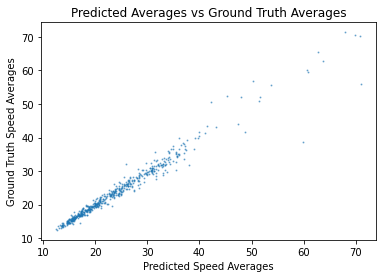

In [62]:
reg = LinearRegression().fit(X_train, y_train) # set to trained linear model
score = reg.score(X_val, y_val) # report r^2 score

# create the scatter plot below
plt.scatter(x = reg.predict(X_val), y = y_val, s = 1, alpha = 0.5);

plt.title('Predicted Averages vs Ground Truth Averages');
plt.ylabel('Ground Truth Speed Averages');
plt.xlabel('Predicted Speed Averages');

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [63]:
score

0.963923292212207

In [64]:
grader.check("q4aii2")

q4aii2 results: All test cases passed!

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [65]:
time_series_x_pre = time_series.iloc[:, 8:13].to_numpy() # get 'time series' dataframe for days 9, 10, 11, 12, 13
time_series_y_post = time_series.iloc[:, 13:14].to_numpy()  # get 'time series' dataframe for 14th

x,y = remove_nans(time_series_x_pre, time_series_y_post)

score_pre_14th = reg.score(x, y)
score_pre_14th

0.9337122097376676

In [66]:
grader.check("q4bi1")

q4bi1 results: All test cases passed!

In [67]:
time_series_x_pre

array([[14.84532001, 14.71153361, 13.73990125, 14.3914358 , 13.95583259],
       [16.17810543, 15.29549397, 14.63710904, 14.28260209, 14.43735825],
       [15.61621536, 14.85047114, 13.79010039, 14.57334878, 15.17725078],
       ...,
       [20.4970768 , 20.40108451, 23.8705369 , 20.2153963 , 20.34313065],
       [32.17986695, 32.9518555 , 31.57452517, 32.17295775, 31.33436375],
       [25.51240295, 24.88606305, 23.90259874, 25.26272056, 24.45002487]])

In [68]:
time_series_y_post

array([[15.87805614],
       [16.09538544],
       [15.17225238],
       [25.00645192],
       [15.1288    ],
       [16.7048158 ],
       [18.77729159],
       [23.98522813],
       [25.03852101],
       [30.76832456],
       [17.77197562],
       [        nan],
       [18.11368942],
       [28.02313988],
       [20.82763148],
       [17.42694207],
       [18.22003466],
       [28.26654435],
       [29.32978935],
       [20.73002755],
       [17.33082953],
       [25.213125  ],
       [35.62818654],
       [60.35547222],
       [15.25889038],
       [18.61711905],
       [30.73814813],
       [31.88187256],
       [31.3947788 ],
       [31.81918147],
       [        nan],
       [25.88585606],
       [18.56674462],
       [18.16756015],
       [17.15433443],
       [16.00452038],
       [60.76129862],
       [        nan],
       [30.60442575],
       [18.3730735 ],
       [18.81192524],
       [17.6888209 ],
       [23.05320108],
       [17.52912136],
       [16.30571395],
       [26

<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

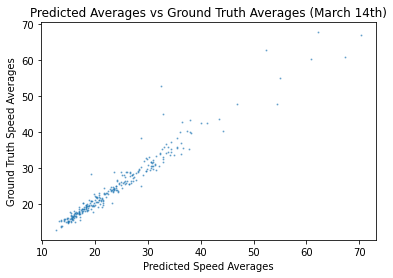

In [69]:
plt.scatter(reg.predict(x), y, s = 1, alpha = 0.5);

plt.title('Predicted Averages vs Ground Truth Averages (March 14th)');
plt.ylabel('Ground Truth Speed Averages');
plt.xlabel('Predicted Speed Averages');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



(2) The lowest point on the line plot is at 17th, reflecting the lowest model performance. 


(3) The model performance begins to worsen on march 15th because the first COVID-related restrictions (travel bans) were announced on March 14. The 5 days that are used to predict the 17th are 12, 13, 14, 15, 16. Half of them are pre-lockdown and the other half are post-lockdown, which makes the model hard to predict the 17th correctly. 


(4) Change in speeds increased sharply around the March 9 according to the line plot for 2aiv, which foreshadows the dip In performance on March 9


(5) The model recovers on its own because the post-lockdown data accumulates enough to enable the model predict using the previous 5 days.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

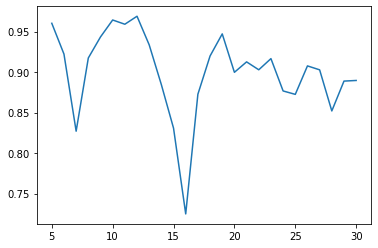

In [70]:
scores = []
for i in np.arange(31 - 5):
    pre_5_days = time_series.iloc[:, i:i+5].to_numpy()
    post = time_series.iloc[:, i+5:i+6].to_numpy()
    x, y = remove_nans(pre_5_days, post)
    scores.append(reg.score(x, y))

plt.plot(np.arange(5, 31), scores);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

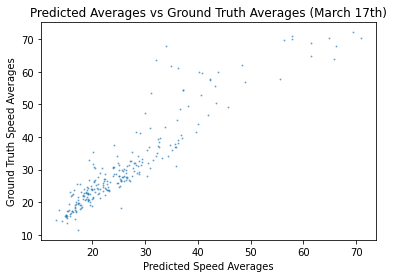

In [71]:
time_series_x_pre_17 = time_series.iloc[:, 11:16].to_numpy() 
time_series_y_17 = time_series.iloc[:, 16:17].to_numpy()

x, y = remove_nans(time_series_x_pre_17, time_series_y_17)

plt.scatter(reg.predict(x), y, s = 1, alpha = 0.5);

plt.title('Predicted Averages vs Ground Truth Averages (March 17th)');
plt.ylabel('Ground Truth Speed Averages');
plt.xlabel('Predicted Speed Averages');

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

**Hint**: As you build your datasets, always check to make sure you're using the right days! It's easy to have a one-off error that throws off your results.

Write your written questions in the next cell, then write the code in the following cells.

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

(4) The delta model is effective for the 17th because there was a relatively large change to the traffic on 14th which affected the prediction for the 17th as explained in 4bii. And delta, or "relative" data, is easier to predict than the "absolute" data because relative difference is more significant than the absolute difference (relative difference shows the scale of the difference).

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [72]:
time_series_delta = time_series_pre - speeds_daily[0:13].array # subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

speed_mph_mean                                                    \
day                     1         2         3         4         5         6    
MOVEMENT_ID                                                                    
9                -7.436210 -7.929735 -7.957726 -7.706332 -7.673488 -8.288859   
20               -6.215082 -6.863900 -6.363125 -6.511982 -6.693731 -6.873540   
21               -8.491956 -9.147858 -8.044932 -7.879632 -7.907553 -8.464493   
44                1.446417  1.167730  0.901289  0.342397 -0.110985  0.981564   
78               -7.458664 -5.569360 -5.787301 -5.813345 -6.320619 -6.303126   
...                    ...       ...       ...       ...       ...       ...   
2691                   NaN       NaN       NaN       NaN -3.385687 -4.313850   
2694             -5.823366 -5.598968 -5.295639 -5.485229 -5.482634 -5.448377   
2695             -3.527067 -2.096006 -1.977287 -1.785869  0.371917 -2.850371   
2700             10.953762  9.047451  9.039961  9.069252  9.650690  8.113142   
2708              1.543108  2.401007  2.303618  2.355356  2.378369  2.989213   

                                                                            \
day                 7          8         9          10        11        12   
MOVEMENT_ID                                                                  
9            -7.342673  -7.838718 -8.163539  -7.950124 -9.037052 -8.687048   
20           -5.762984  -5.960594 -6.830754  -7.366163 -8.139844 -8.795882   
21           -8.893040  -9.407162 -7.392644  -7.811186 -8.986853 -8.505135   
44            0.024509   1.604391  0.492527   0.078211  0.979607  1.910786   
78           -7.548693  -4.765377 -6.755502  -6.530367 -7.003837 -6.987069   
...                ...        ...       ...        ...       ...       ...   
2691          0.621691        NaN -3.970859        NaN       NaN -0.971484   
2694         -5.423980  -5.992169 -5.698587  -5.662927 -5.885166 -6.070161   
2695         -3.627592  -4.578175 -2.511783  -2.260573  1.093583 -2.863087   
2700         10.730575  11.394160  9.171008  10.290198  8.797572  9.094474   
2708          2.700848   2.246655  2.503544   2.224406  1.125645  2.184237   

                       
day                13  
MOVEMENT_ID            
9           -9.364599  
20          -8.883074  
21          -8.143181  
44          -0.144157  
78          -7.112274  
...               ...  
2691              NaN  
2694        -5.761289  
2695        -2.977301  
2700         8.013932  
2708         1.129593  

[295 rows x 13 columns]

In [73]:
grader.check("q4ci2")

q4ci2 results: All test cases passed!

In [74]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset(time_series_delta, 5, 2)

reg_delta = LinearRegression().fit(X_delta_train, y_delta_train)

res_4ci3 = reg_delta.score(X_delta_val, y_delta_val) # learning delta as easy as learning original dataset!
res_4ci3

0.9645254590172871

In [75]:
grader.check("q4ci3")

q4ci3 results: All test cases passed!

In [76]:
time_series_x_pre_17_delta = time_series_x_pre_17 - speeds_daily[11:16].array
time_series_y_17_delta = time_series_y_17 - speeds_daily[17]

x, y = remove_nans(time_series_x_pre_17_delta, time_series_y_17_delta)

res_4ci4 = reg_delta.score(x, y)
res_4ci4

0.8346539614612526

In [77]:
grader.check("q4ci4")

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci4 0
        Failed example:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expected:
            True
        Got:
            False

In [78]:
res_4ci5 = ...

In [79]:
grader.check("q4ci5")

q4ci5 results:
    q4ci5 - 1 result:
        Trying:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci5 0
        Failed example:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4ci5 0[0]>", line 1, in <module>
                np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
              File "<__array_function__ internals>", line 5, in isclose
              File "/opt/conda/lib/python3.9/site-packages/numpy/core/numeric.py", line 2355, in isclose
                xfin = isfinite(x)
            TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [80]:
X_og_train, y_og_train, X_og_val, y_og_val = time_series_to_dataset(time_series.iloc[:, 13:31], 5, 0)

score_og_post = reg.score(X_og_train, y_og_train) 
score_og_post

0.9014738674628209

In [81]:
grader.check("q4cii")

q4cii results: All test cases passed!

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [82]:
X_post_train, y_post_train, X_post_val, y_post_val = time_series_to_dataset(time_series.iloc[:, 13:31], 5, 2)

reg_post = LinearRegression().fit(X_post_train, y_post_train)

score_post = reg_post.score(X_post_val, y_post_val) 
score_post

0.8993687576351703

In [83]:
grader.check("q4ciii")

q4ciii results: All test cases passed!

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [84]:
X_all_train, y_all_train, X_all_val, y_all_val = time_series_to_dataset(time_series, 5, 5)

reg_all = LinearRegression().fit(X_all_train, y_all_train)

res_4civ = reg_all.score(X_all_val, y_all_val) 
res_4civ

0.8843433608623491

In [85]:
grader.check("q4civ")

q4civ results: All test cases passed!

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

In [86]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
import seaborn as sns
import scipy 
from typing import Callable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
 
from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.
The iwut extension is already loaded. To reload it, use:
  %reload_ext iwut


In [87]:
from sklearn.model_selection import cross_val_score

# Useful functions to pass into cross validation
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
def rmse(model, X, y):
    return mean_squared_error(y, model.predict(X), squared=False)
def r2(model, X, y):
    return r2_score(y, model.predict(X))
def assess_accuracy(xtrain, ytrain, xtest, ytest, model):
    cv_scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring=rmse)
    print('RMSE on training data:', rmse(model, xtrain, ytrain))
    print('r2 score on training data:', r2(model, xtrain, ytrain))
    print()
    print('5-Fold Cross Validation rmse mean: ', cv_scores.mean())
    print('5-Fold Cross Validation rmse standard deviation: ', cv_scores.std())
    print()
    print('RMSE on test data:', rmse(model, xtest, ytest))
    print('r2 score on test data:', r2(model, xtest, ytest))
    
    y_pred = model.predict(xtest)
    ax = sns.regplot(x=ytest, y=y_pred, fit_reg=True);
    ax.set_xlabel('Actual Number of Rides')
    ax.set_ylabel('Predicted Number of Rides')
    ax.set_title('Accuracy Report')

In [88]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv('data/movement-speeds-daily-san-francisco-2020-3.csv')

speeds_to_nodes

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean
0,281266,702258940,1,59.674042
1,281266,702274215,1,68.444042
2,302876,240259516,1,66.446500
3,302878,437325360,1,65.516850
4,302883,65381191,1,61.880556
...,...,...,...,...
1586647,6569140748,1350115374,31,68.484833
1586648,6570476556,4551993266,31,36.837000
1586649,6573249373,4911384010,31,39.021000
1586650,6573553681,256888796,31,68.728333


In [89]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

In [90]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [91]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN = r"<node id=\"(\d*)\" lat=\"(.*)\" lon=\"(-\d*.\d*)\""

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130
2,29892598,37.716892,-122.398893
3,30033679,37.599877,-122.376497
4,30033686,37.642167,-122.405946
...,...,...,...
19139,6522255428,37.760543,-122.443563
19140,6522255492,37.759317,-122.444996
19141,6522764204,37.762163,-122.436143
19142,6522764212,37.756061,-122.436761


In [92]:
speeds_to_gps2 = speeds_to_nodes.merge(node_to_gps, left_on='osm_end_node_id', right_on='osm_node_id')
speeds_to_gps2.rename(columns={'Latitude':'endLatitude', 'Longitude':'endLongitude'}, inplace=True)
speeds_to_gps2 = speeds_to_gps2[['day', 'speed_mph_mean', 'endLatitude', 'endLongitude']]

def pickup_scatter(t):
    plt.scatter(t['endLongitude'], t['endLatitude'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')

D = speeds_to_gps2[['endLongitude', 'endLatitude']]
pca_means =  np.mean(D, axis=0)
X = (D - pca_means)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """Add a region column to t based on vt above."""
    D = t[['endLongitude', 'endLatitude']]
    assert D.shape[0] == t.shape[0], 'You set D using the incorrect table'
    # Always use the same data transformation used to compute vt
    X = (D - pca_means) 
    first_pc = X@ vt.T[:, 0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])

add_region(speeds_to_gps2)
speeds_to_gps2.head()

,day,speed_mph_mean,endLatitude,endLongitude,region
0,1,64.478000,37.67381,-122.38993,0
1,2,62.868208,37.67381,-122.38993,0
2,3,62.211750,37.67381,-122.38993,0
3,4,62.192458,37.67381,-122.38993,0
4,5,61.913292,37.67381,-122.38993,0


In [93]:
#import csv that contains the coordinates, neighborhood, and business category for every business in SF
business_locations = pd.read_csv('data/Registered_Business_Locations_-_San_Francisco (cleaned).csv')

#keep only the columns we are interested in
business_locations = business_locations[['NAICS Code Description', 'Neighborhoods - Analysis Boundaries', 'Latitude', 'Longitude']]

#remove nan values in NAICS code description, rename and round columns 
business_locations = business_locations[business_locations['NAICS Code Description'].notna()]
business_locations.rename(columns={'NAICS Code Description':'Business Category', 'Neighborhoods - Analysis Boundaries':'Neighborhood'}, inplace=True)
business_locations = business_locations.round(4)
business_locations.head()

,Business Category,Neighborhood,Latitude,Longitude
0,"Professional, Scientific, and Technical Services",Mission Bay,37.7748,-122.3957
1,"Professional, Scientific, and Technical Services",South of Market,37.7750,-122.4038
2,Private Education and Health Services,Inner Richmond,37.7741,-122.4646
4,Private Education and Health Services,Inner Richmond,37.7741,-122.4646
5,Retail Trade,Financial District/South Beach,37.7879,-122.4000


In [94]:
speeds_to_gps_rounded = speeds_to_gps2.round(4)
business_data = business_locations.merge(speeds_to_gps_rounded, how='inner', left_on=['Latitude', 'Longitude'], right_on=['endLatitude', 'endLongitude'])
business_data

,Business Category,Neighborhood,Latitude,Longitude,day,speed_mph_mean,endLatitude,endLongitude,region
0,Real Estate and Rental and Leasing Services,Financial District/South Beach,37.7895,-122.4021,1,14.4549,37.7895,-122.4021,2
1,Real Estate and Rental and Leasing Services,Financial District/South Beach,37.7895,-122.4021,2,11.5638,37.7895,-122.4021,2
2,Real Estate and Rental and Leasing Services,Financial District/South Beach,37.7895,-122.4021,3,10.5426,37.7895,-122.4021,2
3,Real Estate and Rental and Leasing Services,Financial District/South Beach,37.7895,-122.4021,4,10.6856,37.7895,-122.4021,2
4,Real Estate and Rental and Leasing Services,Financial District/South Beach,37.7895,-122.4021,5,10.8249,37.7895,-122.4021,2
...,...,...,...,...,...,...,...,...,...
27911,Food Services,Chinatown,37.7973,-122.4020,12,17.1623,37.7973,-122.4020,2
27912,Food Services,Chinatown,37.7973,-122.4020,13,19.2058,37.7973,-122.4020,2
27913,Food Services,Chinatown,37.7973,-122.4020,14,22.4647,37.7973,-122.4020,2
27914,Food Services,Chinatown,37.7973,-122.4020,15,24.9440,37.7973,-122.4020,2


In [95]:
grouped_business_data = business_data.groupby(['Business Category', 'day']).count()
grouped_business_data = grouped_business_data[['Neighborhood']]
grouped_business_data.rename(columns={'Neighborhood':'Number of Rides'}, inplace=True)
grouped_business_data.reset_index(inplace=True)
grouped_business_data.head()

,Business Category,day,Number of Rides
0,Accommodations,1,21
1,Accommodations,2,23
2,Accommodations,3,21
3,Accommodations,4,21
4,Accommodations,5,22


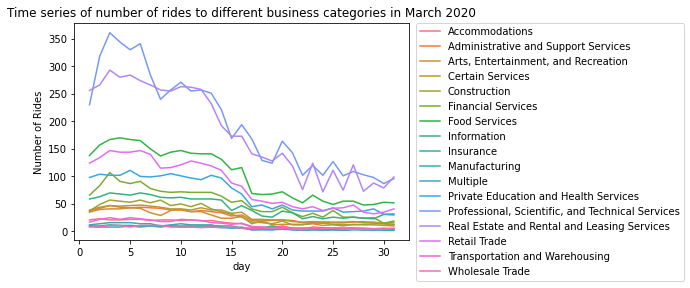

In [96]:
#eda #1

sns.lineplot(data = grouped_business_data, x='day', y='Number of Rides', hue='Business Category', legend=False);
plt.legend(grouped_business_data['Business Category'].unique(), bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);
plt.title('Time series of number of rides to different business categories in March 2020');

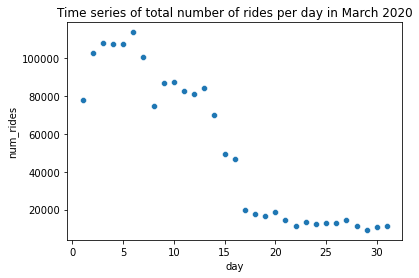

In [97]:
#the previous graph was very messy so let's not aggregate by business category and just graph a time series of total rides per day 
#eda #2
rides_per_day = speeds_to_nodes.groupby('day').count()
rides_per_day.rename(columns={'osm_start_node_id':'num_rides'}, inplace=True)
rides_per_day = rides_per_day[['num_rides']]

sns.scatterplot(x='day', y='num_rides', data=rides_per_day);
plt.title('Time series of total number of rides per day in March 2020');

Text(0.5, 1.0, 'Rides per region over Time')

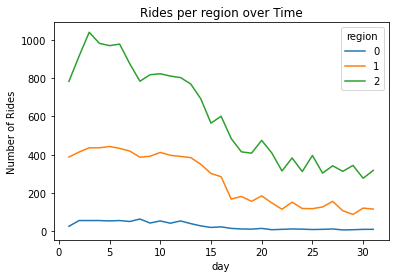

In [98]:
grouped_business_data2 = business_data.groupby(['region', 'day']).count()
grouped_business_data2 = grouped_business_data2[['Neighborhood']]
grouped_business_data2.rename(columns={'Neighborhood':'Number of Rides'}, inplace=True)
grouped_business_data2.reset_index(inplace=True)
sns.lineplot(data=grouped_business_data2, x="day" , y="Number of Rides" , hue='region')
plt.title("Rides per region over Time")

Text(0.5, 1.0, 'Number of rides for business category across regions')

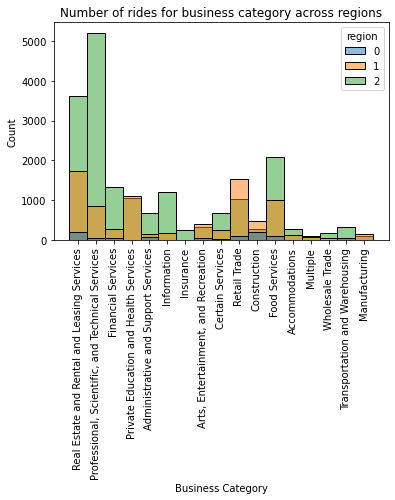

In [99]:
sns.histplot(data=business_data,  x='Business Category' , hue='region')
plt.xticks(rotation=90)
plt.title("Number of rides for business category across regions")

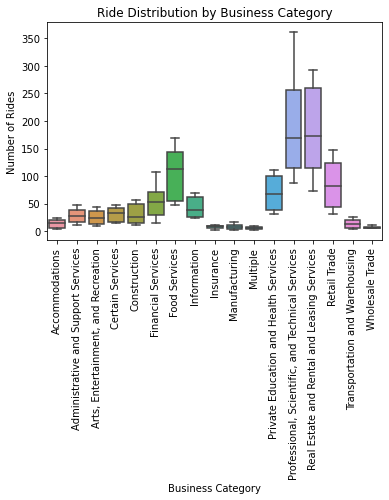

In [100]:
sns.boxplot(x="Business Category" , y='Number of Rides', data= grouped_business_data);
plt.xticks(rotation=90);
plt.title('Ride Distribution by Business Category');

Average rides per day post-lockdown:  514.2
Unique business categories:  17
Average number of rides per day to each business category:  30.247058823529414


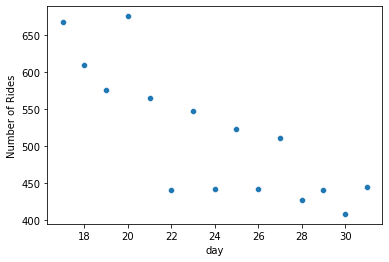

In [101]:
post_covid_grouped_ride_data = grouped_business_data[grouped_business_data['day'] > 16]
num_business_categories = post_covid_grouped_ride_data['Business Category'].nunique()

post_covid_data_aggregated = post_covid_grouped_ride_data.groupby('day').sum()
post_covid_data_aggregated

sns.scatterplot(x='day', y='Number of Rides', data=post_covid_data_aggregated);
print('Average rides per day post-lockdown: ', np.mean(post_covid_data_aggregated['Number of Rides']))
print('Unique business categories: ', num_business_categories)
print('Average number of rides per day to each business category: ', np.mean(post_covid_data_aggregated['Number of Rides'])/17)

In [102]:
#ok, number of rides seems to be negatively correlated with day. let's train a model with features day and ohe business category

In [103]:
model_v1_grouped_business_data = grouped_business_data.copy()
model_v1_grouped_business_data.head()

from sklearn.preprocessing import OneHotEncoder

oh_category = OneHotEncoder()
oh_category.fit(model_v1_grouped_business_data[['Business Category']])

model_v1_oh_data = model_v1_grouped_business_data.join(pd.DataFrame(oh_category.transform(model_v1_grouped_business_data[['Business Category']]).todense(), 
                           columns=oh_category.get_feature_names(),
                           index = model_v1_grouped_business_data.index)).drop(columns='Business Category')
model_v1_oh_data.head()

,day,Number of Rides,x0_Accommodations,x0_Administrative and Support Services,"x0_Arts, Entertainment, and Recreation",x0_Certain Services,x0_Construction,x0_Financial Services,x0_Food Services,x0_Information,x0_Insurance,x0_Manufacturing,x0_Multiple,x0_Private Education and Health Services,"x0_Professional, Scientific, and Technical Services",x0_Real Estate and Rental and Leasing Services,x0_Retail Trade,x0_Transportation and Warehousing,x0_Wholesale Trade
0,1,21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,22,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
model_v1_training_set = model_v1_oh_data[model_v1_oh_data['day'] < 26]
model_v1_test_set = model_v1_oh_data[model_v1_oh_data['day'] >= 26]

X_train1, y_train1 = model_v1_training_set.drop(columns=['Number of Rides']), model_v1_training_set['Number of Rides']
X_test1, y_test1 = model_v1_test_set.drop(columns=['Number of Rides']), model_v1_test_set['Number of Rides']

RMSE on training data: 24.609335126180778
r2 score on training data: 0.8800916959345015

5-Fold Cross Validation rmse mean:  59.63913277132574
5-Fold Cross Validation rmse standard deviation:  30.14427486597667

RMSE on test data: 37.345331887258844
r2 score on test data: -0.6799563701434723


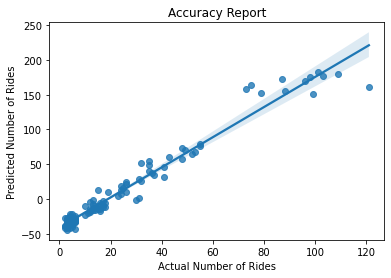

In [105]:
model_v1 = LinearRegression()
model_v1.fit(X_train1, y_train1)

assess_accuracy(X_train1, y_train1, X_test1, y_test1, model_v1)

In [106]:
#how can we improve this model? we had a revalation. 

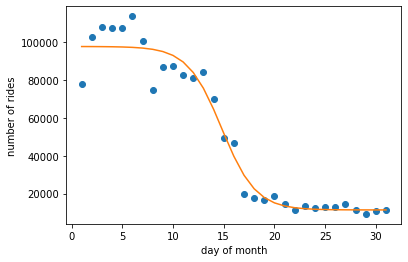

array([86.233283  , 11.40924267, -0.59491899, 14.79776833])

In [107]:
x = np.array(rides_per_day.index)
y = np.array(rides_per_day['num_rides']) / 1000

def f(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

popt, pcov = scipy.optimize.curve_fit(f, x, y, method="trf", p0=np.array([100, 1, 1, 17]))
y_fit = f(x, *popt)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y*1000, 'o')
ax.plot(x, y_fit*1000, '-')
ax.set_ylabel('number of rides')
ax.set_xlabel('day of month')
plt.show()
popt

In [108]:
#fit logistic curve to train dataset

train_set = grouped_business_data[grouped_business_data['day'] < 26][['Business Category', 'day', 'Number of Rides']]
test_set = grouped_business_data[grouped_business_data['day'] >= 26][['Business Category', 'day', 'Number of Rides']]
train_set.head()

,Business Category,day,Number of Rides
0,Accommodations,1,21
1,Accommodations,2,23
2,Accommodations,3,21
3,Accommodations,4,21
4,Accommodations,5,22


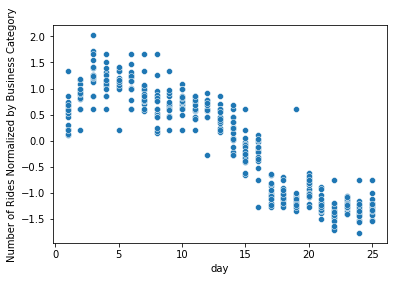

In [109]:
category_normalized_rides = train_set.groupby('Business Category')[['Number of Rides']].transform(lambda x: (x - x.mean()) / x.std())
category_normalized_rides.rename(columns={'Number of Rides':'Number of Rides Normalized by Business Category'}, inplace=True)
category_normalized_rides['Business Category'] = train_set['Business Category']
category_normalized_rides['day'] = train_set['day']

sns.scatterplot(x='day', y='Number of Rides Normalized by Business Category', data=category_normalized_rides);

Logistic Curve Parameters:  -2.271 | 0.953 | 0.528 | 15.011


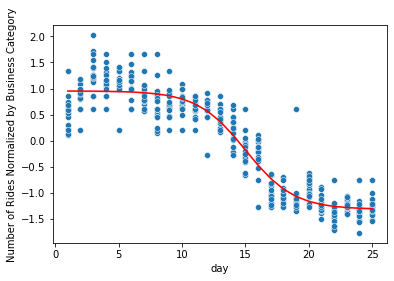

In [110]:
import scipy

x = np.array(category_normalized_rides['day'])
y = np.array(category_normalized_rides['Number of Rides Normalized by Business Category'])

def f(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x-d))) + b

popt, pcov = scipy.optimize.curve_fit(f, x, y, method='trf')
y_fit = f(x, *popt)
ax = sns.scatterplot(x=x, y=y)
sns.lineplot(x=x, y=y_fit, color='red')
ax.set_xlabel('day')
ax.set_ylabel('Number of Rides Normalized by Business Category')

a = popt[0].round(3)
b = popt[1].round(3)
c = popt[2].round(3)
d = popt[3].round(3)
print('Logistic Curve Parameters: ', a,"|", b, "|", c, "|",d)

In [111]:
def apply_logistic(grouped_business_data, logistic_parameters):
    a = logistic_parameters[0]
    b = logistic_parameters[1]
    c = logistic_parameters[2]
    d = logistic_parameters[3]
    
    logistic = grouped_business_data.copy()
    
    category_std = logistic.groupby('Business Category')[['Number of Rides']].transform(lambda x: np.std(x))
    category_mean = logistic.groupby('Business Category')[['Number of Rides']].transform(lambda x: np.mean(x))
    
    logistic['category_std'] = category_std
    logistic['category_mean'] = category_mean
    
    logistic['normalized logistic-predicted num_rides'] = a / (1+np.exp(-c * (logistic['day'] - d))) + b
    
    logistic['logistic-predicted num_rides'] = logistic['normalized logistic-predicted num_rides'] * logistic['category_std'] + logistic['category_mean']
    
    return logistic

In [112]:
grouped_business_data.head()

,Business Category,day,Number of Rides
0,Accommodations,1,21
1,Accommodations,2,23
2,Accommodations,3,21
3,Accommodations,4,21
4,Accommodations,5,22


In [113]:
model_v2_data = apply_logistic(grouped_business_data, popt)

model_v2_data.head()

,Business Category,day,Number of Rides,category_std,category_mean,normalized logistic-predicted num_rides,logistic-predicted num_rides
0,Accommodations,1,21,7.196369,13.225806,0.952066,20.077223
1,Accommodations,2,23,7.196369,13.225806,0.951095,20.070234
2,Accommodations,3,21,7.196369,13.225806,0.949451,20.058402
3,Accommodations,4,21,7.196369,13.225806,0.946670,20.038390
4,Accommodations,5,22,7.196369,13.225806,0.941972,20.004586


In [114]:
model_v2_training_set = model_v2_data[model_v2_data['day'] < 26]
model_v2_test_set = model_v2_data[model_v2_data['day'] >= 26]

X_train2, y_train2 = model_v2_training_set[['logistic-predicted num_rides']], model_v2_training_set['Number of Rides']
X_test2, y_test2 = model_v2_test_set[['logistic-predicted num_rides']], model_v2_test_set['Number of Rides']

RMSE on training data: 10.59550996807101
r2 score on training data: 0.9777723664446082

5-Fold Cross Validation rmse mean:  9.022353801036274
5-Fold Cross Validation rmse standard deviation:  5.879575734917293

RMSE on test data: 5.700489651089894
r2 score on test data: 0.9608573991395687


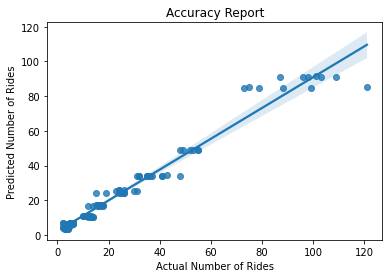

In [115]:
model_v2 = LinearRegression()

model_v2.fit(X_train2, y_train2)

assess_accuracy(X_train2, y_train2, X_test2, y_test2, model_v2)

In [116]:
#one-hot encode weekday and business category

model_v3_data = model_v2_data.copy()

model_v3_data['weekday'] = model_v3_data['day'] % 7

oh_weekday = OneHotEncoder()
oh_weekday.fit(model_v3_data[['weekday']])

oh_category = OneHotEncoder()
oh_category.fit(model_v3_data[['Business Category']])

model_v3_data.head()

,Business Category,day,Number of Rides,category_std,category_mean,normalized logistic-predicted num_rides,logistic-predicted num_rides,weekday
0,Accommodations,1,21,7.196369,13.225806,0.952066,20.077223,1
1,Accommodations,2,23,7.196369,13.225806,0.951095,20.070234,2
2,Accommodations,3,21,7.196369,13.225806,0.949451,20.058402,3
3,Accommodations,4,21,7.196369,13.225806,0.946670,20.038390,4
4,Accommodations,5,22,7.196369,13.225806,0.941972,20.004586,5


In [117]:
model_v3_data = model_v3_data[['Business Category', 'day', 'Number of Rides', 'weekday', 'logistic-predicted num_rides']].join(pd.DataFrame(oh_weekday.transform(model_v3_data[['weekday']]).todense(), 
                           columns=oh_weekday.get_feature_names(),
                           index = model_v3_data.index)).drop(columns='weekday')
model_v3_data = model_v3_data.join(pd.DataFrame(oh_category.transform(model_v3_data[['Business Category']]).todense(), 
                           columns=oh_category.get_feature_names(),
                           index = model_v3_data.index)).drop(columns='Business Category')
model_v3_data.head()

,day,Number of Rides,logistic-predicted num_rides,x0_0,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,...,x0_Information,x0_Insurance,x0_Manufacturing,x0_Multiple,x0_Private Education and Health Services,"x0_Professional, Scientific, and Technical Services",x0_Real Estate and Rental and Leasing Services,x0_Retail Trade,x0_Transportation and Warehousing,x0_Wholesale Trade
0,1,21,20.077223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,23,20.070234,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,21,20.058402,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,21,20.038390,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,22,20.004586,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
model_v3_training_set = model_v3_data[model_v3_data['day'] < 26]
model_v3_test_set = model_v3_data[model_v3_data['day'] >= 26]

X_train3, y_train3 = model_v3_training_set.drop(columns=['day', 'Number of Rides']), model_v3_training_set['Number of Rides']
X_test3, y_test3 = model_v3_test_set.drop(columns=['day', 'Number of Rides']), model_v3_test_set['Number of Rides']

RMSE on training data: 8.8844377369996
r2 score on training data: 0.9843717843304516

5-Fold Cross Validation rmse mean:  10.691421404658426
5-Fold Cross Validation rmse standard deviation:  5.310245716967265

RMSE on test data: 7.755085876355414
r2 score on test data: 0.9275566410445779


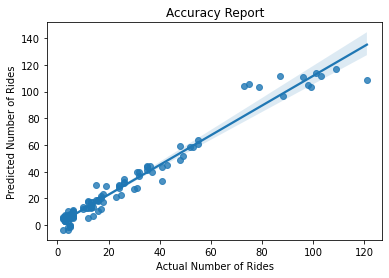

In [119]:
model_v3 = LinearRegression()
model_v3.fit(X_train3, y_train3)

assess_accuracy(X_train3, y_train3, X_test3, y_test3, model_v3)

In [120]:
model_v4_data = model_v3_data.copy()
model_v4_data = model_v4_data.loc[:, 'day':'x0_6']
model_v4_data.head()

,day,Number of Rides,logistic-predicted num_rides,x0_0,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6
0,1,21,20.077223,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,23,20.070234,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,21,20.058402,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,21,20.038390,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,22,20.004586,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [121]:
model_v4_training_set = model_v4_data[model_v4_data['day'] < 26]
model_v4_test_set = model_v4_data[model_v4_data['day'] >= 26]

X_train4, y_train4 = model_v4_training_set.drop(columns=['day', 'Number of Rides']), model_v4_training_set['Number of Rides']
X_test4, y_test4 = model_v4_test_set.drop(columns=['day', 'Number of Rides']), model_v4_test_set['Number of Rides']

RMSE on training data: 10.082350815679089
r2 score on training data: 0.9798732751749359

5-Fold Cross Validation rmse mean:  8.948284904232287
5-Fold Cross Validation rmse standard deviation:  5.371806622847929

RMSE on test data: 6.183435537359443
r2 score on test data: 0.953944125673844


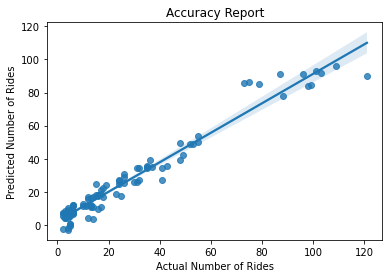

In [122]:
model_v4 = LinearRegression()
model_v4.fit(X_train4, y_train4)

assess_accuracy(X_train4, y_train4, X_test4, y_test4, model_v4)

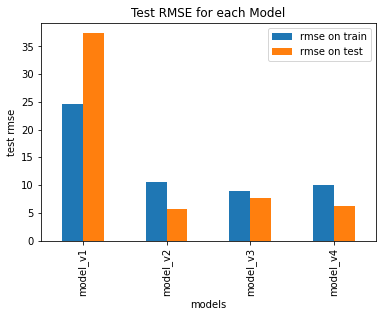

In [123]:
rmse_data= [['model_v1', rmse(model_v1, X_train1, y_train1), rmse(model_v1, X_test1, y_test1)],
            ['model_v2', rmse(model_v2, X_train2, y_train2), rmse(model_v2, X_test2, y_test2)],
            ['model_v3', rmse(model_v3, X_train3, y_train3), rmse(model_v3, X_test3, y_test3)],
            ['model_v4', rmse(model_v4, X_train4, y_train4), rmse(model_v4, X_test4, y_test4)]
           ]
rmse_df = pd.DataFrame(rmse_data, columns=['model','rmse on train','rmse on test'])
rmse_df.plot(x='model', y=['rmse on train','rmse on test'], kind='bar', title = 'Test RMSE for each Model', xlabel = 'models', ylabel = 'test rmse');

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [124]:
grader.check_all()

q1a results: All test cases passed!

q1bi results: All test cases passed!

q1bii results: All test cases passed!

q1biii results: All test cases passed!

q1biv results: All test cases passed!

q1bv3 results: All test cases passed!

q1ci results: All test cases passed!

q1cii results: All test cases passed!

q1ciii results: All test cases passed!

q1civ3 results: All test cases passed!

q2ai2 results: All test cases passed!

q2ai3 results: All test cases passed!

q2ai4 results: All test cases passed!

q2aii2 results: All test cases passed!

q2aiii results: All test cases passed!

q2aiv3 results: All test cases passed!

q2av2 results: All test cases passed!

q4ai1 results: All test cases passed!

q4ai2 results: All test cases passed!

q4ai3 results: All test cases passed!

q4aii2 results: All test cases passed!

q4bi1 results: All test cases passed!

q4ci2 results: All test cases passed!

q4ci3 results: All test cases passed!

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
        

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [125]:
# Save your notebook first, then run this cell to export your submission.
grader.export()